# 0. Imports

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Preamble analysis of the dataset

In [38]:
df = pd.read_csv("./data/covid_data.csv");
df.head()

,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,DATE_DIED,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,...,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU
0,2,1,1,1,03/05/2020,97,1,65,2,2,...,2,2,1,2,2,2,2,2,3,97
1,2,1,2,1,03/06/2020,97,1,72,97,2,...,2,2,1,2,2,1,1,2,5,97
2,2,1,2,2,09/06/2020,1,2,55,97,1,...,2,2,2,2,2,2,2,2,3,2
3,2,1,1,1,12/06/2020,97,2,53,2,2,...,2,2,2,2,2,2,2,2,7,97
4,2,1,2,1,21/06/2020,97,2,68,97,1,...,2,2,1,2,2,2,2,2,3,97


In [39]:
boolean_columns = ["INTUBED", "PNEUMONIA", "PREGNANT", "DIABETES", "COPD", "ASTHMA", "INMSUPR", "HIPERTENSION", "OTHER_DISEASE", "CARDIOVASCULAR", "OBESITY", "RENAL_CHRONIC", "TOBACCO", "ICU"]

# Replace 97 and 99 with NA for the boolean columns
df[boolean_columns] = df[boolean_columns].replace({1: True, 2: False, 97: None, 98: None, 99: None})
df.head()

,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,DATE_DIED,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,...,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU
0,2,1,1,1,03/05/2020,None,True,65,False,False,...,False,False,True,False,False,False,False,False,3,None
1,2,1,2,1,03/06/2020,None,True,72,None,False,...,False,False,True,False,False,True,True,False,5,None
2,2,1,2,2,09/06/2020,True,False,55,None,True,...,False,False,False,False,False,False,False,False,3,False
3,2,1,1,1,12/06/2020,None,False,53,False,False,...,False,False,False,False,False,False,False,False,7,None
4,2,1,2,1,21/06/2020,None,False,68,None,True,...,False,False,True,False,False,False,False,False,3,None


In [40]:
df["DEAD"] = [x != "9999-99-99" for x in df["DATE_DIED"]]
df.head()

,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,DATE_DIED,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,...,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU,DEAD
0,2,1,1,1,03/05/2020,None,True,65,False,False,...,False,True,False,False,False,False,False,3,None,True
1,2,1,2,1,03/06/2020,None,True,72,None,False,...,False,True,False,False,True,True,False,5,None,True
2,2,1,2,2,09/06/2020,True,False,55,None,True,...,False,False,False,False,False,False,False,3,False,True
3,2,1,1,1,12/06/2020,None,False,53,False,False,...,False,False,False,False,False,False,False,7,None,True
4,2,1,2,1,21/06/2020,None,False,68,None,True,...,False,True,False,False,False,False,False,3,None,True


### 1.1 Handling NA values

As we can show with the following graph, there are **a lot** of NA values in the dataset. We will have to handle them.

One approach is to take the mean of the column and replace the NA values with it. However, this is not a good approach, as it will skew the data. We will have to find a better way to handle the NA values.

The other approach is to remove the rows with NA values. This is a better approach, but it will reduce the size of the dataset. We will make this sacrifice for the sake of accuracy.

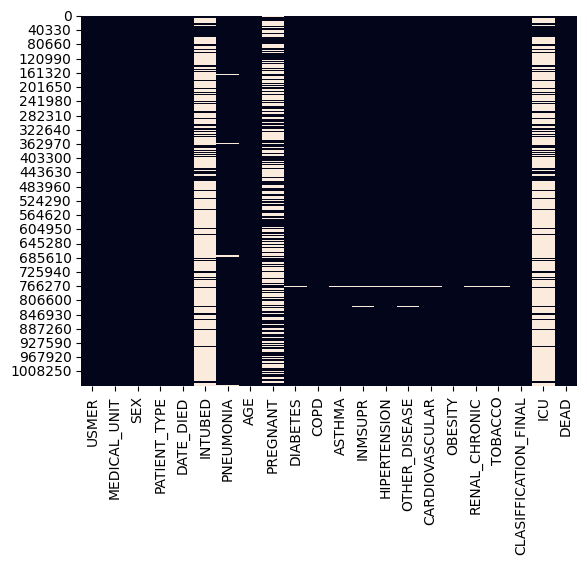

In [41]:
sns.heatmap(df.isnull(), cbar=False)
plt.show()

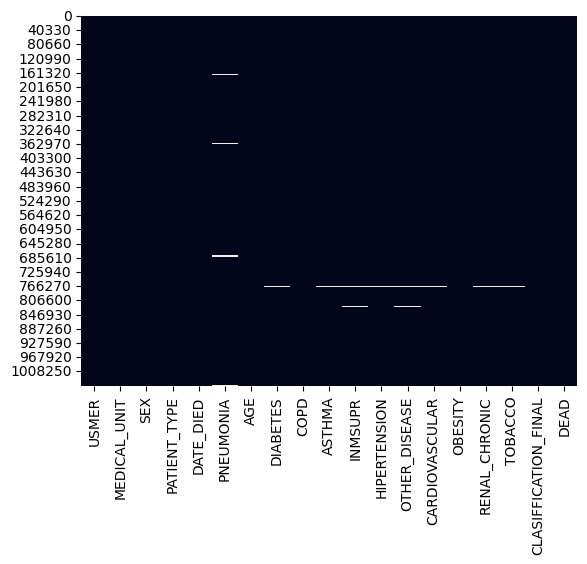

In [46]:
columns_to_delete = []
for column in df.columns:
    if df[column].isnull().sum() > 0.5 * df.shape[0]:
        columns_to_delete.append(column)
        
df = df.drop(columns_to_delete, axis=1)

sns.heatmap(df.isnull(), cbar=False)
plt.show()